In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import sys
sys.path.append('../acd/acd')

In [2]:
import os
vector_cache = os.path.join(os.getcwd(), '.vector_cache/input_vectors.pt')
word_vectors ='glove.6B.300d'
batch_size=  50


In [3]:
sst_pkl = pickle.load(open('../acd/dsets/sst/sst.pkl', 'rb'))

In [4]:

sys.path.append('../acd/visualization')
sys.path.append('../acd/acd/util')
sys.path.append('../acd/acd/scores')
sys.path.append('../acd/acd/agglomeration')
import viz_1d as viz
import tiling_1d as tiling
import agg_1d as agg
import cd
import score_funcs

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# form class to hold data
class B:
    text = torch.zeros(1).to(device)
sys.path.append('../acd')
sys.path.append('../acd/dsets/sst')
from dsets.sst import dset
from dsets.sst.model import LSTMSentiment

# check out how two models differ
import torch.optim as O
import torch.nn as nn

from torchtext import data
from torchtext import datasets

In [5]:

inputs = data.Field(lower= True)
answers = data.Field(sequential=False, unk_token=None)

train, dev, test = datasets.SST.splits(inputs, answers, fine_grained=False, train_subtrees=True,
                                       filter_pred=lambda ex: ex.label != 'neutral')

inputs.build_vocab(train, dev, test)
if word_vectors:
    if os.path.isfile(vector_cache):
        inputs.vocab.vectors = torch.load(vector_cache)
    else:
        inputs.vocab.load_vectors(word_vectors)
        makedirs(os.path.dirname(vector_cache))
        torch.save(inputs.vocab.vectors,vector_cache)
answers.build_vocab(train)

train_iter, dev_iter, test_iter = data.BucketIterator.splits(
    (train, dev, test), batch_size=batch_size, device=torch.device(0))

In [6]:
train_iter, dev_iter, test_iter = data.BucketIterator.splits(
    (train, dev, test), batch_size=batch_size, device=torch.device(0))

In [7]:

model1 = torch.load('models/model3.pt', map_location=torch.device(0))
model2 = torch.load('models/model1.pt', map_location=torch.device(0))

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'model.LSTMSentiment' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [61]:
num_batches = 17
is_correct = np.zeros((2,(num_batches)*batch_size))

In [62]:
model1.eval()
model2.eval()

LSTMSentiment(
  (embed): Embedding(18844, 300)
  (lstm): LSTM(300, 128)
  (hidden_to_label): Linear(in_features=128, out_features=2, bias=True)
)

In [123]:
with torch.no_grad():
    # check out how two models differ
    import torch.optim as O
    import torch.nn as nn
    criterion = nn.CrossEntropyLoss()
    n_dev_correct, dev_loss = 0, 0
    cur_idx = 0
    for dev_batch_idx, dev_batch in enumerate(dev_iter):

        if dev_batch_idx >num_batches-1:
            break
        answer1 = nn.functional.softmax(model1(dev_batch))
        answer2  = nn.functional.softmax(model2(dev_batch))
        is_correct[0, cur_idx:cur_idx + dev_batch.label.shape[0]] = answer1[:,0].cpu().numpy() #(torch.max(answer1, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data).cpu().numpy()
        is_correct[1, cur_idx:cur_idx + dev_batch.label.shape[0]] =  answer2[:,0].cpu().numpy()#(torch.max(answer2, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data).cpu().numpy()

        cur_idx+=dev_batch.label.shape[0]
        n_dev_correct += (((torch.max(answer1, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data)+
        (torch.max(answer2, 1)[1].view(dev_batch.label.size()).data == dev_batch.label.data))>=1).sum()
        dev_loss = criterion(answer1, dev_batch.label)
    dev_acc = 100. * n_dev_correct / len(dev)

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


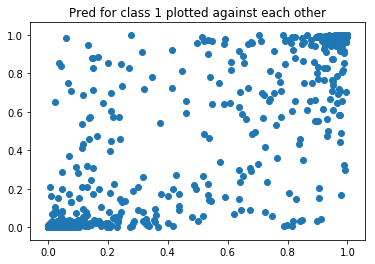

In [124]:
plt.scatter(is_correct[0], is_correct[1])
plt.title("Pred for class 1 plotted against each other")
plt.savefig("Plot_train_set")

In [196]:
int_ind = np.where((is_correct[0] ==0)* (is_correct[1]==1))[0]
#int_ind = np.array([int_ind //50, int_ind%50])

In [147]:
def single_batch(nump):
    batch = B()
    nums = np.expand_dims(nump.transpose(), axis=1)
    batch.text = torch.LongTensor(nums).to(device) #cuda()
    return batch

In [148]:
def batch_from_str_list(s):
    batch = B()
    nums = np.expand_dims(np.array([sst_pkl['stoi'][x] for x in s]).transpose(), axis=1)
    print(nums.shape)
    batch.text = torch.LongTensor(nums).to(device) #cuda()
    return batch

In [186]:
def str_from_array(arr):

    return [sst_pkl['itos'][idx] for idx in arr if idx!=1 ]
    
def batch_from_str_list(s):
    batch = B()
    nums = np.expand_dims(np.array([sst_pkl['stoi'][x] for x in s]).transpose(), axis=1)
    batch.text = torch.LongTensor(nums).to(device) #cuda()
    return batch
def get_spec_index(idx,train_iter, dev_iter,  my_dset='train'):
    which_batch = idx//batch_size
    batch =dset.get_batches([which_batch,], train_iter, dev_iter, dset=my_dset)
    text = batch[idx//batch_size].text[:, idx%batch_size].cpu().numpy()
    label =batch[idx//batch_size].label[ idx%batch_size].cpu().numpy()

    return text[np.where(text!=1)], label

In [185]:
get_spec_index(3)

(array([ 309,   10,   96,   86,  101,   12,   21,  637, 6947,    6,    4,
        4403, 4176]), array(0))

In [174]:
" ".join(str_from_array(get_spec_index(9858)[0]))

'an enjoyable 100 minutes in a movie theater'

In [175]:
model1(single_batch(get_spec_index(32)[0]))

tensor([[-0.2753,  0.7368]], device='cuda:0', grad_fn=<AddmmBackward>)

/home/lauri/.conda/envs/gpu_usage/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


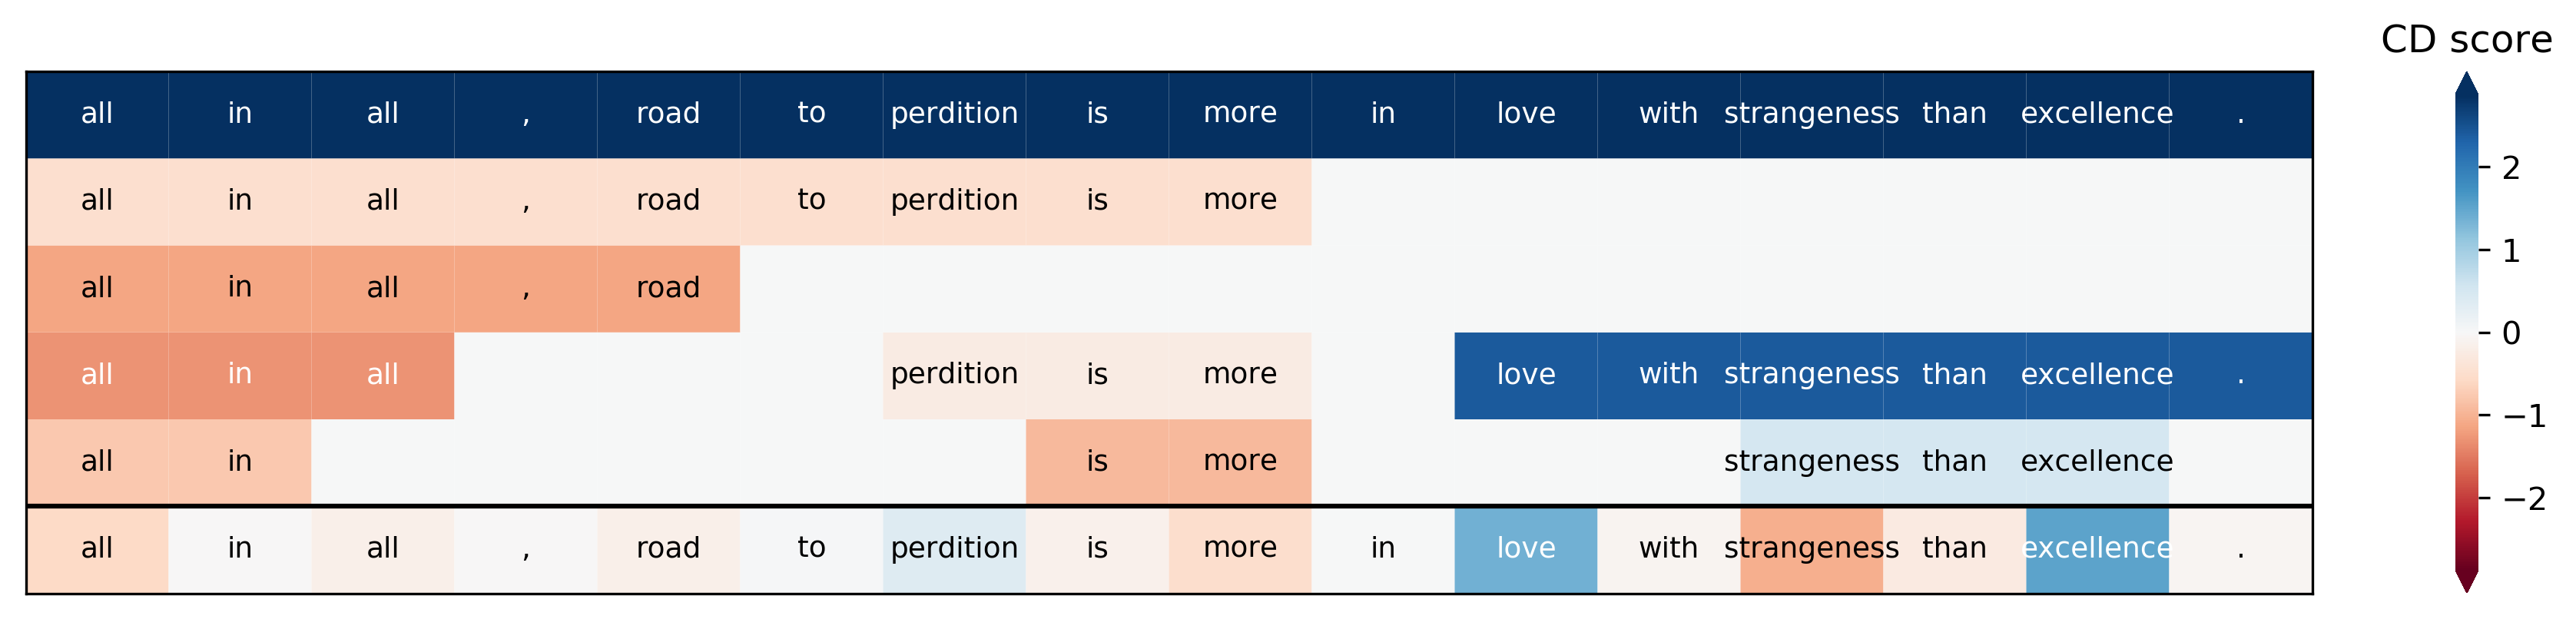

In [179]:
which_idx =int_ind[1]

# base parameters
sweep_dim = 1 # how large chunks of text should be considered (1 for words)
method = 'cd' # build_up, break_down, cd
percentile_include = 99.5 # keep this very high so we don't add too many words at once
num_iters = 25 # maximum number of iterations (rarely reached)
arr, label =get_spec_index(32)
# text and label
sentence = str_from_array(arr)
# label = 1 # 0 if positive 1 if negative



# prepare inputs
batch = single_batch(arr)
scores_all = model1(batch).data.cpu().numpy()[0] # predict
label_pred = np.argmax(scores_all) # get predicted class

# agglomerate
lists = agg.agglomerate(model1, batch, percentile_include, method, sweep_dim, # only works for sweep_dim = 1
                    label_pred, num_iters=num_iters, device=device) # see agg_1d.agglomerate to understand what this dictionary contains
lists = agg.collapse_tree(lists) # don't show redundant joins

# visualize
viz.word_heatmap(sentence, lists, label_pred, label, fontsize=9)

In [ ]:
# workflow:

# we work on already trained models
# load both models
# 1 is student, 2 is teacher
# identify where 1 is wrong, 2 is correct
# 